## REINFORCE CARTPOLE KERAS using FIT

https://github.com/rlcode/reinforcement-learning/blob/master/2-cartpole/3-reinforce/cartpole_reinforce.py


REINFORCE is an on-policy, Monte Carlo policy gradient algorithm used to directly optimize the parameters of a stochastic policy.

Instead of learning a value function (like Q-learning), REINFORCE learns the parameters of the policy function to maximize expected reward.

In [10]:
import sys
import gymnasium as gym
import pylab
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import os
import time

import sys
sys.stderr = open('err.txt', 'w')

import tensorflow as tf
tf.keras.backend.set_floatx('float32')

In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


### Hyperparameters

In [3]:

EPISODES = 2000
learning_rate = 0.0001
ROLLING_WINDOW = 40
solved_threshold = 195
MAX_EPISODES = 2000

### Agent training made with method .FIT

In [4]:
# This is Policy Gradient agent for the Cartpole
# In this example, we use REINFORCE algorithm which uses monte-carlo update rule

class REINFORCEAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.98
        self.learning_rate = 0.0001
        self.hidden1, self.hidden2 = 48, 48

        # create model for policy network
        self.model = self.build_model()

        # lists for the states, actions and rewards
        self.states, self.actions, self.rewards = [], [], []

        if self.load_model:
            self.model.load_weights("./save_model/cartpole_reinforce.h5")

    # approximate policy using Neural Network
    # state is input and probability of each action is output of network
    
    def build_model(self):
        
        custom_opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                          amsgrad=True, clipnorm=1.0)
        
        model = Sequential()
        model.add(Dense(self.hidden1, input_dim=self.state_size, activation='relu',dtype='float32'))
        model.add(Dense(self.hidden2, activation='relu',dtype='float32'))
        model.add(Dense(self.action_size, activation='softmax',dtype='float32'))
        model.summary()
        
        # Using sparse categorical crossentropy as a loss is a trick to easily
        # implement the policy gradient. Categorical cross entropy is defined
        # H(p, q) = sum(p_i * log(q_i)). For the action taken, a, you set 
        # p_a = advantage. q_a is the output of the policy network, which is
        # the probability of taking the action a, i.e. policy(s, a). 
        # All other p_i are zero, thus we have H(p, q) = A * log(policy(s, a))
        
        model.compile(loss='sparse_categorical_crossentropy', optimizer=custom_opt)
        return model

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        
        policy = self.model.predict(state, batch_size=1, verbose=0).flatten()
        policy /= np.sum(policy)  # Prevents issues if softmax is slightly off
        
        # Add small epsilon to prevent issues with zero probabilities
        policy = np.clip(policy, 1e-8, 1.0)
        policy = policy / np.sum(policy)
        
        action = np.random.choice(self.action_size, 1, p=policy)[0]

        return action

    # In Policy Gradient, Q function is not available.
    # Instead agent uses sample returns for evaluating policy
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    # save <s, a ,r> of each step
    def append_sample(self, state, action, reward):
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)

    # update policy network every episode
    def train_model(self):
        """Training using sparse categorical crossentropy with sample weights"""
        if len(self.states) == 0:
            return
            
        episode_length = len(self.states)
        
        # Compute and normalize discounted rewards
        discounted_rewards = self.discount_rewards(self.rewards)
        discounted_rewards -= np.mean(discounted_rewards)
        if np.std(discounted_rewards) > 0:
            discounted_rewards /= np.std(discounted_rewards)
        
        # Prepare data
        states = np.array(self.states, dtype=np.float32)
        actions = np.array(self.actions, dtype=np.int32)
        
        # Use sample weights to weight the loss by advantages
        # For policy gradients, we want to increase probability of good actions
        # and decrease probability of bad actions
        sample_weights = discounted_rewards.astype(np.float32)
        
        states = states.squeeze(axis=1)
        # Train using fit with sample weights
        self.model.fit(states, actions, 
                      sample_weight=sample_weights,
                      epochs=1, verbose=0)
        
        # Clear episode memory
        self.states, self.actions, self.rewards = [], [], []



In [5]:
# Main Loop
start_time = time.time()
env = gym.make('CartPole-v1')
    # get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

    # make REINFORCE agent
agent = REINFORCEAgent(state_size, action_size)

scores, episodes, rolling_avg_rewards = [], [], []

for e in range(EPISODES):
    done = False
    score, step = 0, 0
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:
        step = step + 1
        if agent.render:
            env.render()

        # get action for the current state and go one step in environment
        action = agent.get_action(state)
        next_state, reward, done, _, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        reward = reward if not done or score == 499 else -100

        # save the sample <s, a, r> to the memory
        agent.append_sample(state, action, reward)

        score = score + reward
        state = next_state

        if done:
            break

    # every episode, agent learns from sample returns
    agent.train_model()

    score = score if score == 500 else score + 100
    scores.append(score)
    total_reward = score
    rolling_avg = np.mean(scores[-ROLLING_WINDOW:])   # append rewards
    rolling_avg_rewards.append(rolling_avg)
    print(f"Episode: {e+1:3}/{MAX_EPISODES}, Reward: {total_reward:+7.2f}, "
              f"Rolling Avg: {rolling_avg:6.2f}, Steps: {step:3} Terminated: {done} ")

    # break if score reaches threshold
    avg_score = np.mean(scores[-ROLLING_WINDOW:])
    if avg_score > solved_threshold:
        break           

env.close()
end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Training completed in {testing_duration:.2f} minutes")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            98 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,690 (10.51 KB)

 Trainable params: 2,690 (10.51 KB)

 Non-trainable params: 0 (0.00 B)

Episode:   1/2000, Reward:  +10.00, Rolling Avg:  10.00, Steps:  11 Terminated: True 
Episode:   2/2000, Reward:  +14.00, Rolling Avg:  12.00, Steps:  15 Terminated: True 
Episode:   3/2000, Reward:  +13.00, Rolling Avg:  12.33, Steps:  14 Terminated: True 
Episode:   4/2000, Reward:  +11.00, Rolling Avg:  12.00, Steps:  12 Terminated: True 
Episode:   5/2000, Reward:   +9.00, Rolling Avg:  11.40, Steps:  10 Terminated: True 
Episode:   6/2000, Reward:  +13.00, Rolling Avg:  11.67, Steps:  14 Terminated: True 
Episode:   7/2000, Reward:  +13.00, Rolling Avg:  11.86, Steps:  14 Terminated: True 
Episode:   8/2000, Reward:  +17.00, Rolling Avg:  12.50, Steps:  18 Terminated: True 
Episode:   9/2000, Reward:  +11.00, Rolling Avg:  12.33, Steps:  12 Terminated: True 
Episode:  10/2000, Reward:  +14.00, Rolling Avg:  12.50, Steps:  15 Terminated: True 
Episode:  11/2000, Reward:   +9.00, Rolling Avg:  12.18, Steps:  10 Terminated: True 
Episode:  12/2000, Reward:  +24.00, Rolling Avg:  13.1

Episode:  97/2000, Reward:  +11.00, Rolling Avg:  20.10, Steps:  12 Terminated: True 
Episode:  98/2000, Reward:  +35.00, Rolling Avg:  20.23, Steps:  36 Terminated: True 
Episode:  99/2000, Reward:  +49.00, Rolling Avg:  21.10, Steps:  50 Terminated: True 
Episode: 100/2000, Reward:  +11.00, Rolling Avg:  21.07, Steps:  12 Terminated: True 
Episode: 101/2000, Reward:  +10.00, Rolling Avg:  20.82, Steps:  11 Terminated: True 
Episode: 102/2000, Reward:  +17.00, Rolling Avg:  20.77, Steps:  18 Terminated: True 
Episode: 103/2000, Reward:  +12.00, Rolling Avg:  20.65, Steps:  13 Terminated: True 
Episode: 104/2000, Reward:  +21.00, Rolling Avg:  20.60, Steps:  22 Terminated: True 
Episode: 105/2000, Reward:  +18.00, Rolling Avg:  20.15, Steps:  19 Terminated: True 
Episode: 106/2000, Reward:   +9.00, Rolling Avg:  20.05, Steps:  10 Terminated: True 
Episode: 107/2000, Reward:  +11.00, Rolling Avg:  19.20, Steps:  12 Terminated: True 
Episode: 108/2000, Reward:  +21.00, Rolling Avg:  19.5

Episode: 193/2000, Reward:  +46.00, Rolling Avg:  45.85, Steps:  47 Terminated: True 
Episode: 194/2000, Reward:  +18.00, Rolling Avg:  45.50, Steps:  19 Terminated: True 
Episode: 195/2000, Reward: +104.00, Rolling Avg:  47.27, Steps: 105 Terminated: True 
Episode: 196/2000, Reward:  +21.00, Rolling Avg:  47.58, Steps:  22 Terminated: True 
Episode: 197/2000, Reward:  +87.00, Rolling Avg:  49.02, Steps:  88 Terminated: True 
Episode: 198/2000, Reward:  +33.00, Rolling Avg:  48.52, Steps:  34 Terminated: True 
Episode: 199/2000, Reward:  +78.00, Rolling Avg:  49.67, Steps:  79 Terminated: True 
Episode: 200/2000, Reward:  +87.00, Rolling Avg:  51.27, Steps:  88 Terminated: True 
Episode: 201/2000, Reward:  +18.00, Rolling Avg:  50.30, Steps:  19 Terminated: True 
Episode: 202/2000, Reward:  +69.00, Rolling Avg:  51.52, Steps:  70 Terminated: True 
Episode: 203/2000, Reward: +111.00, Rolling Avg:  53.38, Steps: 112 Terminated: True 
Episode: 204/2000, Reward: +150.00, Rolling Avg:  56.0

Episode: 289/2000, Reward: +129.00, Rolling Avg: 149.62, Steps: 130 Terminated: True 
Episode: 290/2000, Reward: +211.00, Rolling Avg: 153.82, Steps: 212 Terminated: True 
Episode: 291/2000, Reward: +161.00, Rolling Avg: 156.47, Steps: 162 Terminated: True 
Episode: 292/2000, Reward: +167.00, Rolling Avg: 159.95, Steps: 168 Terminated: True 
Episode: 293/2000, Reward: +117.00, Rolling Avg: 160.97, Steps: 118 Terminated: True 
Episode: 294/2000, Reward: +159.00, Rolling Avg: 164.22, Steps: 160 Terminated: True 
Episode: 295/2000, Reward:  +96.00, Rolling Avg: 164.53, Steps:  97 Terminated: True 
Episode: 296/2000, Reward:  +72.00, Rolling Avg: 165.50, Steps:  73 Terminated: True 
Episode: 297/2000, Reward:  +72.00, Rolling Avg: 166.10, Steps:  73 Terminated: True 
Episode: 298/2000, Reward:  +83.00, Rolling Avg: 167.12, Steps:  84 Terminated: True 
Episode: 299/2000, Reward:  +60.00, Rolling Avg: 167.65, Steps:  61 Terminated: True 
Episode: 300/2000, Reward:  +87.00, Rolling Avg: 168.1

### Training evolution visualization

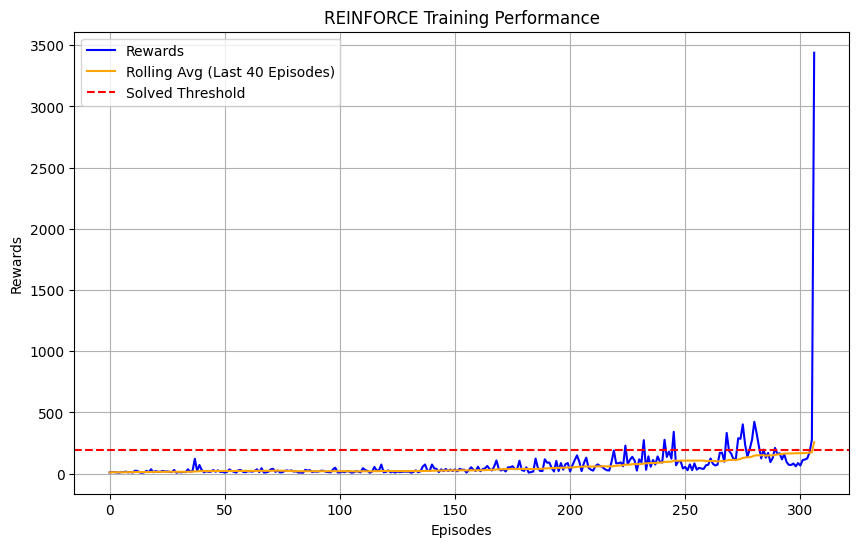

In [6]:
# Plot rewards with rolling average
plt.figure(figsize=(10, 6))
plt.plot(scores, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last '+str(ROLLING_WINDOW)+' Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('REINFORCE Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

In [7]:
# Using Policy to select next action

# Testing for 10 episodes
start_time = time.time()
max_steps = 500

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    for s in range(max_steps):                            # we limit because sometimes it goes ad-aeternum
        # Use the trained model for testing
        
        action = agent.get_action(state)                  

        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1

        if done or (steps == max_steps):
            print(f"Test Episode: {e_test + 1}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode: 1/10, Reward: 500.00, Steps: 500
Test Episode: 2/10, Reward: 500.00, Steps: 500
Test Episode: 3/10, Reward: 500.00, Steps: 500
Test Episode: 4/10, Reward: 500.00, Steps: 500
Test Episode: 5/10, Reward: 500.00, Steps: 500
Test Episode: 6/10, Reward: 500.00, Steps: 500
Test Episode: 7/10, Reward: 500.00, Steps: 500
Test Episode: 8/10, Reward: 500.00, Steps: 500
Test Episode: 9/10, Reward: 500.00, Steps: 500
Test Episode: 10/10, Reward: 500.00, Steps: 500
Testing completed in 3.04 minutes


In [8]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(("CartPole-v1"), render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    
    action = agent.get_action(state)                  # We use the policy to get the next action

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='CARTPOLE_REINFORCE_FIT.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='CARTPOLE_REINFORCE_FIT.gif')

Rendered Test Episode Reward: 500.00
Saved GIF to: ./CARTPOLE_REINFORCE_FIT.gif


In [9]:
import session_info
session_info.show(html=False)

-----
PIL                 10.4.0
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
pylab               NA
session_info        1.0.0
tensorflow          2.19.0
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
Linux-6.6.87.1-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-06-11 12:19
